# MountainCar

In [1]:
import gym
import numpy as np
from tqdm import tqdm  # shows where we are through training
import matplotlib.pyplot as plt   # to show off results

MountainCar gives the position and velocity in the range $\left[ -1.2, 0.6 \right] \times\left[ -0.07, 0.07 \right]$.

In [2]:
env_name = "MountainCar-v0"

gamma = 0.98 # discount factor (want it high because we only care about the end)
alpha = 0.05  # learning rate (could probably be even higher since MountainCar is small)

state_size = 2   # state dimension
state_min = [-1.2, -0.07] # min state output
state_max = [ 0.6,  0.07] # max state output

action_size = 3   # 0, 1, or 2

num_intervals = [25,60]   # this includes outside of the min and max
num_trials = 75000
test_freq = 500   # after how many trials do we want to look at results?
num_tests = 5    # how many tests in each test
extra_tests = 1000   # at the end, how many additional tests do we want to do that are not rendered?

epsilon = 1  # start by moving randomly
epsilon_min = .01  # minimum epsilon
epsilon_episodes = int(num_trials/2)  # after this many episodes, have epsilon_min

In [3]:
# This is a generic interval maker that makes uniform intervals, there's a VERY good chance that you won't actually want this
# for an actual use case, however here we have no reason not to use a uniform interval (as we don't have any additional useful
# information)


def interval_maker(mins, maxs, interval_size, prec=5):
    my_list = [[i] for i in mins]   # for the number of dimensions in each state,
                                    # make a list in this list and initialize to the mins
    for i, size in enumerate(interval_size):
        length = round((maxs[i] - mins[i])/(-2+size), prec)   # length of the interval
        for j in range(size-3):
            my_list[i].append(round(my_list[i][-1]+length, prec))  # appended the next cutoff point,
                                                                   # round to 'prec' decimal places
        my_list[i].append(maxs[i])

    return my_list



# A function to map states to indices

def s_to_index(state):
    state_list = [0 for i in range(state_size)]   # will store which intervals we are in
    for i in range(state_size):
        for idx, num in enumerate(state_intervals[i]):
            if state[i] < num:   # break once we have found the interval
                state_list[i] = idx
                break
    output = state_list[0]
    for i in range(1,state_size):
        output += state_list[i]*np.product(num_intervals[:i])
    return int(output)



# A function to select an action based on the current Q table and epsilon

def select_action(state_index, eps, Q):
    if np.random.ra()nd < eps:   # chance we pick a random action
        return np.random.randint(action_size)
    else:   # otherwise, pick what we think is best
        return np.argmax(Q[state_index])



# Test current Q_table
def tester(Q, env):
    super_total = 0
    for _ in range(num_tests):
        done = False
        total = 0
        s = env.reset()
        while not done:
            s_idx = s_to_index(s)
            a = select_action(s_idx, 0, Q)   # epsilon = 0 means always choose best action
            s, r, done, _ = env.step(a)
            total += r
        super_total += total
    return super_total/num_tests   # return average total score
    


# Efficiently computes moving averages

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [4]:
# Housekeeping stuff
env = gym.make(env_name)   # create environment
epsilon_decay = (epsilon-epsilon_min)/epsilon_episodes # how quickly epsilon decays
# Q_table = np.random.rand(*[np.product(num_intervals), action_size])-0.5   # initialize Q table randomly (centered around 0)
Q_table = np.zeros([np.product(num_intervals), action_size])    # (can also initialize to zero)

state_intervals = interval_maker(state_min, state_max, num_intervals)  # helps determine state
print('[')
for thing in state_intervals:
    print(str(thing) + ',')
print(']')

# For Visualization of Results
rewards_list = []
max_pos_list = []
test_rewards = []

[
[-1.2, -1.12174, -1.04348, -0.96522, -0.88696, -0.8087, -0.73044, -0.65218, -0.57392, -0.49566, -0.4174, -0.33914, -0.26088, -0.18262, -0.10436, -0.0261, 0.05216, 0.13042, 0.20868, 0.28694, 0.3652, 0.44346, 0.52172, 0.6],
[-0.07, -0.06759, -0.06518, -0.06277, -0.06036, -0.05795, -0.05554, -0.05313, -0.05072, -0.04831, -0.0459, -0.04349, -0.04108, -0.03867, -0.03626, -0.03385, -0.03144, -0.02903, -0.02662, -0.02421, -0.0218, -0.01939, -0.01698, -0.01457, -0.01216, -0.00975, -0.00734, -0.00493, -0.00252, -0.00011, 0.0023, 0.00471, 0.00712, 0.00953, 0.01194, 0.01435, 0.01676, 0.01917, 0.02158, 0.02399, 0.0264, 0.02881, 0.03122, 0.03363, 0.03604, 0.03845, 0.04086, 0.04327, 0.04568, 0.04809, 0.0505, 0.05291, 0.05532, 0.05773, 0.06014, 0.06255, 0.06496, 0.06737, 0.07],
]


In [5]:
# Train
for test_num in tqdm(range(num_trials)):
    s = env.reset()   # starting state
    s_idx = s_to_index(s)   # starting state's index
    done = False   # whether we're done with the episode
    total_score = 0  # keep track of total score
    max_pos = -1.6   # keep track of max pos
    while not done:   # go til done
        a = select_action(s_idx, epsilon, Q_table)   # select action
        new_s, r, done, _ = env.step(a)   # record new state, the reward, and whether we're done ('_' is info we don't want)
        new_s_idx = s_to_index(new_s)   # new index

        if not done:
            Q_table[s_idx, a] = (1-alpha)*Q_table[s_idx, a] + alpha*(r + gamma*np.max(Q_table[new_s_idx]))   # update Q table
        else:
            Q_table[s_idx, a] = (1-alpha)*Q_table[s_idx, a] + alpha*r   # if done, there is no future

        max_pos = max(max_pos, min(new_s[0], 0.5))   # keep track of new max_pos
        total_score += r   # add to total score

        s = new_s   # update state
        s_idx = new_s_idx   # and state index
    
    max_pos_list.append(max_pos)   # store max_pos
    rewards_list.append(total_score)   # store reward
    epsilon = max(epsilon_min, epsilon-epsilon_decay)   # decay epsilon
    
    if test_num % test_freq == 0:
        test_rewards.append(tester(Q_table, env))
    

100%|██████████████████████████████████████████████████████████████████| 75000/75000 [16:03<00:00, 77.83it/s]


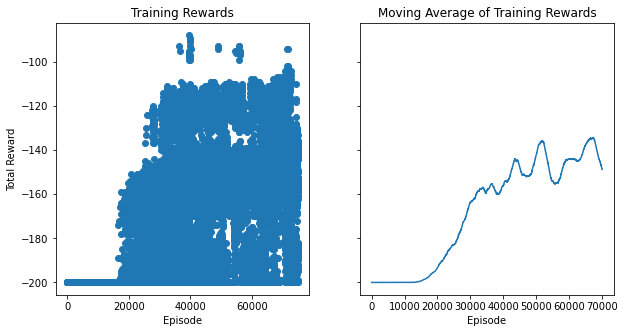

In [6]:
moving_average_len = int(np.floor(len(rewards_list)/15))
moving_average = running_mean(rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Rewards')
ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

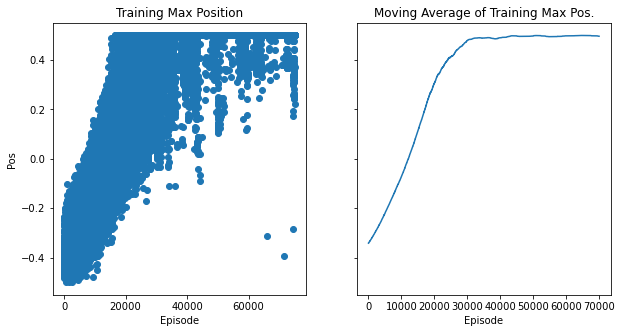

In [7]:
moving_average_len = int(np.floor(len(max_pos_list)/15))
moving_average = running_mean(max_pos_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Max Position')
ax1.scatter([i+1 for i in range(len(max_pos_list))], max_pos_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Pos')


ax2.set_title('Moving Average of Training Max Pos.')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

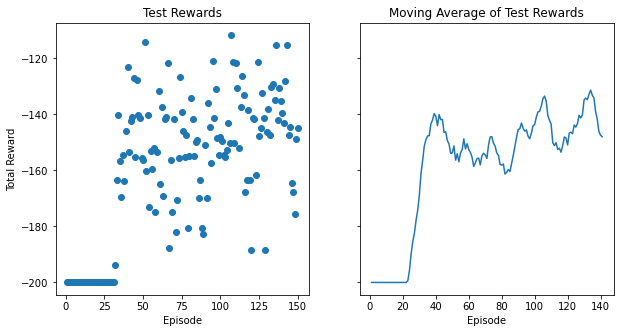

In [8]:
moving_average_len = int(np.floor(len(test_rewards)/15))
moving_average = running_mean(test_rewards, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Test Rewards')
ax1.scatter([i+1 for i in range(len(test_rewards))], test_rewards)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Test Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

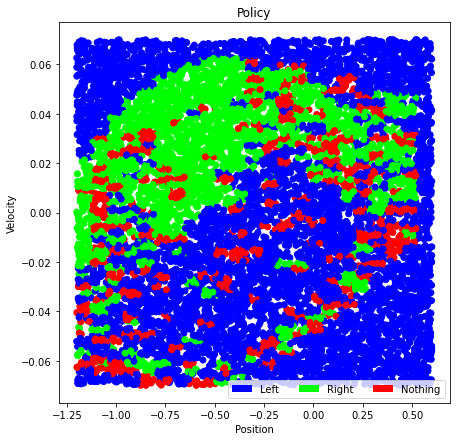

In [9]:
import pandas as pd
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    fake_state_index = s_to_index(np.array([X[i], Y[i]]))
    Z.append(select_action(fake_state_index, 0, Q_table))   # select action
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy.png')
plt.show()

In [10]:
super_total = 0
for _ in range(extra_tests):
    done = False
    total = 0
    s = env.reset()
    while not done:
        s_idx = s_to_index(s)
        a = select_action(s_idx, 0, Q_table)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        total += r
    super_total += total
for _ in range(num_tests):
    done = False
    total = 0
    s = env.reset()
    env.render()
    while not done:
        s_idx = s_to_index(s)
        a = select_action(s_idx, 0, Q_table)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        env.render()
        total += r
    super_total += total
print("Average Reward: {}".format(round(super_total/(num_tests+extra_tests), 5)))   # return average total score
env.close()

Average Reward: -153.08657


# Modifed MountainCar

Here, we change the reward structure by rewarding the car for being closer to the goal.  Nothing else has changed.  This typically speeds up the training process and has a more well-defined policy.

In [11]:
# Housekeeping stuff
env = gym.make(env_name)   # create environment
epsilon_decay = (epsilon-epsilon_min)/epsilon_episodes # how quickly epsilon decays
# mod_Q_table = np.random.rand(*[np.product(num_intervals), action_size])-0.5   # initialize Q table randomly (centered around 0)
mod_Q_table = np.zeros([np.product(num_intervals), action_size])    # (can also initialize to zero)

state_intervals = interval_maker(state_min, state_max, num_intervals)  # helps determine state
print('[')
for thing in state_intervals:
    print(str(thing) + ',')
print(']')

# For Visualization of Results
rewards_list = []
max_pos_list = []
test_rewards = []
true_rewards_list = []

[
[-1.2, -1.12174, -1.04348, -0.96522, -0.88696, -0.8087, -0.73044, -0.65218, -0.57392, -0.49566, -0.4174, -0.33914, -0.26088, -0.18262, -0.10436, -0.0261, 0.05216, 0.13042, 0.20868, 0.28694, 0.3652, 0.44346, 0.52172, 0.6],
[-0.07, -0.06759, -0.06518, -0.06277, -0.06036, -0.05795, -0.05554, -0.05313, -0.05072, -0.04831, -0.0459, -0.04349, -0.04108, -0.03867, -0.03626, -0.03385, -0.03144, -0.02903, -0.02662, -0.02421, -0.0218, -0.01939, -0.01698, -0.01457, -0.01216, -0.00975, -0.00734, -0.00493, -0.00252, -0.00011, 0.0023, 0.00471, 0.00712, 0.00953, 0.01194, 0.01435, 0.01676, 0.01917, 0.02158, 0.02399, 0.0264, 0.02881, 0.03122, 0.03363, 0.03604, 0.03845, 0.04086, 0.04327, 0.04568, 0.04809, 0.0505, 0.05291, 0.05532, 0.05773, 0.06014, 0.06255, 0.06496, 0.06737, 0.07],
]


In [12]:
# Train
action_test = [0,0,0]
for test_num in tqdm(range(num_trials)):
    s = env.reset()   # starting state
    s_idx = s_to_index(s)   # starting state's index
    done = False   # whether we're done with the episode
    total_score = 0  # keep track of total score
    true_score = 0
    max_pos = -1.6   # keep track of max pos
    while not done:   # go til done
        a = select_action(s_idx, epsilon, mod_Q_table)   # select action
        new_s, r, done, _ = env.step(a)   # record new state, the reward, and whether we're done ('_' is info we don't want)
        new_s_idx = s_to_index(new_s)   # new index
        
        true_score -= 1
        
        r += min(new_s[0], 0.5)/25   # slight reward for being close to flag
                                     # Note: flag is at 0.5, no additional reward for being further

        if not done:
            mod_Q_table[s_idx, a] = (1-alpha)*mod_Q_table[s_idx, a] + alpha*(r + gamma*np.max(mod_Q_table[new_s_idx]))   # update Q table
        else:
            mod_Q_table[s_idx, a] = (1-alpha)*mod_Q_table[s_idx, a] + alpha*r   # if done, there is no future

        max_pos = max(max_pos, min(new_s[0], 0.5))   # keep track of new max_pos
        total_score += r   # add to total score

        s = new_s   # update state
        s_idx = new_s_idx   # and state index
    
    max_pos_list.append(max_pos)
    true_rewards_list.append(true_score)
    rewards_list.append(total_score)
    epsilon = max(epsilon_min, epsilon-epsilon_decay)
    
    if test_num % test_freq == 0:
        test_rewards.append(tester(mod_Q_table, env))

100%|██████████████████████████████████████████████████████████████████| 75000/75000 [15:16<00:00, 81.80it/s]


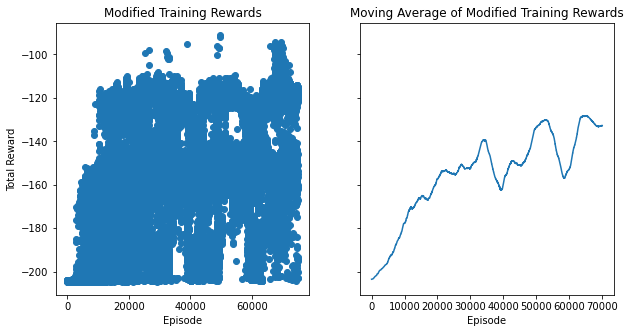

In [13]:
moving_average_len = int(np.floor(len(rewards_list)/15))
moving_average = running_mean(rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Modified Training Rewards')
ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Modified Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

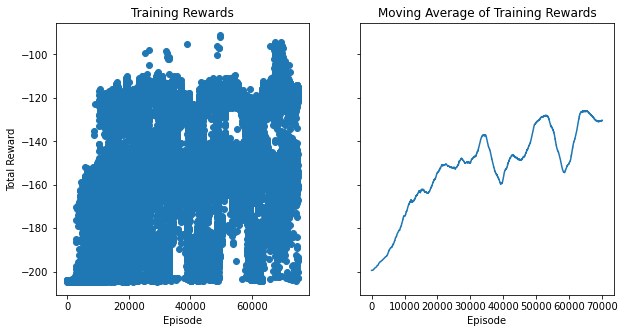

In [14]:
moving_average_len = int(np.floor(len(true_rewards_list)/15))
moving_average = running_mean(true_rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Rewards')
ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

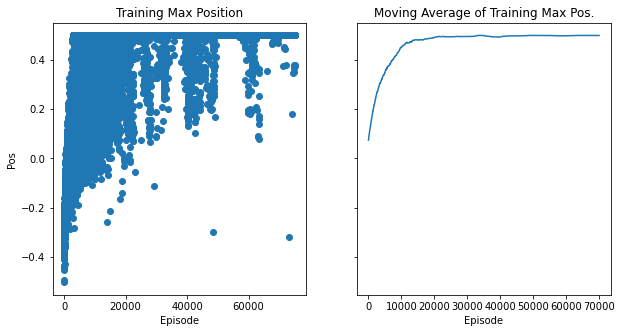

In [15]:
moving_average_len = int(np.floor(len(max_pos_list)/15))
moving_average = running_mean(max_pos_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Max Position')
ax1.scatter([i+1 for i in range(len(max_pos_list))], max_pos_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Pos')


ax2.set_title('Moving Average of Training Max Pos.')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

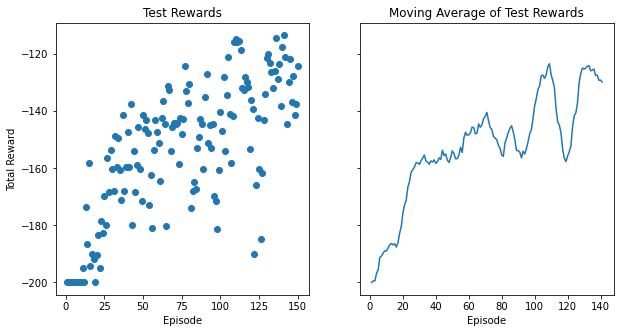

In [16]:
moving_average_len = int(np.floor(len(test_rewards)/15))
moving_average = running_mean(test_rewards, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Test Rewards')
ax1.scatter([i+1 for i in range(len(test_rewards))], test_rewards)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Test Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

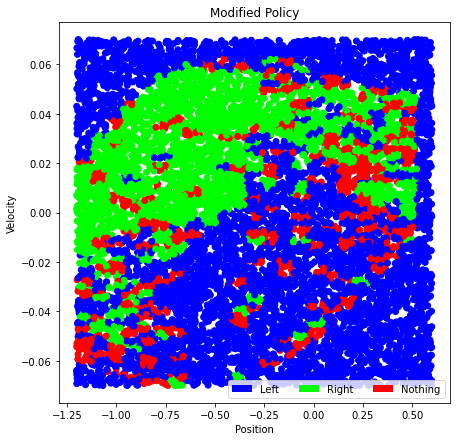

In [17]:
import pandas as pd
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    fake_state_index = s_to_index(np.array([X[i], Y[i]]))
    Z.append(select_action(fake_state_index, 0, mod_Q_table))   # select action
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Modified Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy - Modified.png')
plt.show()

In [18]:
super_total = 0
for _ in range(extra_tests):
    done = False
    total = 0
    s = env.reset()
    while not done:
        s_idx = s_to_index(s)
        a = select_action(s_idx, 0, mod_Q_table)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        total += r
    super_total += total
for _ in range(num_tests):
    done = False
    total = 0
    s = env.reset()
    env.render()
    while not done:
        s_idx = s_to_index(s)
        a = select_action(s_idx, 0, mod_Q_table)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        env.render()
        total += r
    super_total += total
print("Average Reward: {}".format(round(super_total/(num_tests+extra_tests), 5)))   # return average total score
env.close()

Average Reward: -122.35622
